# Solving 2D Poisson Equation using Physics-Informed Neural Networks (PINNs)

## Introduction

In this tutorial, we will solve the poisson equation on a square domain $[0,1]^2$ with homogeneous Dirichlet boundary conditions $(u = 0$ on the boundary).
In two dimensions, it takes the form:

$-\Delta u = f(x,y)$

where:
* $\Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$ is the Laplacian operator.
* $u(x,y)$ is the unknown function we want to solve for.
* $f(x,y)$ is a known source function.



## 1. Importing the required libraries

In [36]:
import tensorflow as tf
import pyDOE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seeds for reproducibility

tf.random.set_seed(42)
#set device to cuda

def set_device():
    """
    Configure and select the computational device (GPU/CPU).

    Returns:
        str: Device identifier ('/GPU:0' or '/CPU:0')
    """
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("Using GPU")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        return '/GPU:0'
    print("Using CPU")
    return '/CPU:0'

device = set_device()


Using GPU


In [37]:
print(device)

/GPU:0


### Latin Hypercube Sampling with pyDOE

Latin hypercube sampling (LHS) is a statistical method for generating a near random samples with equal intervals.


why lhs?


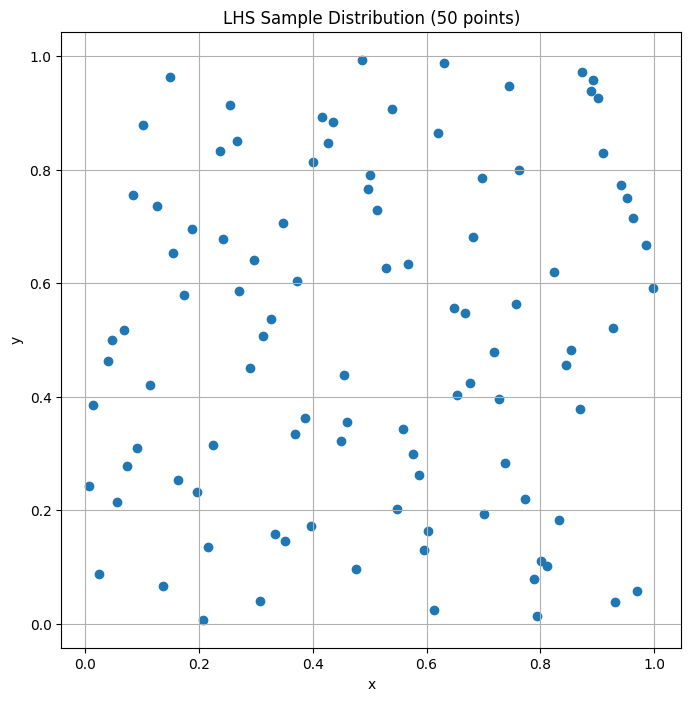

In [38]:
# Generate and visualize samples
samples = pyDOE.lhs(2, samples=100)
plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1])
plt.grid(True)
plt.title('LHS Sample Distribution (50 points)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Generate Training Points

We'll generate two sets of points to train our Physics-Informed Neural Network:

1. **Boundary Points**: These points lie on the edges of our domain $[0,1]^2$
   * Generated using Latin Hypercube Sampling (LHS)
   * Used to enforce Dirichlet boundary conditions $(u = 0)$
2. **Interior Points**: These points fill the inside of our domain
   * Also generated using Latin Hypercube Sampling
   * Used to enforce the PDE $(\nabla^2u = f(x,y))$



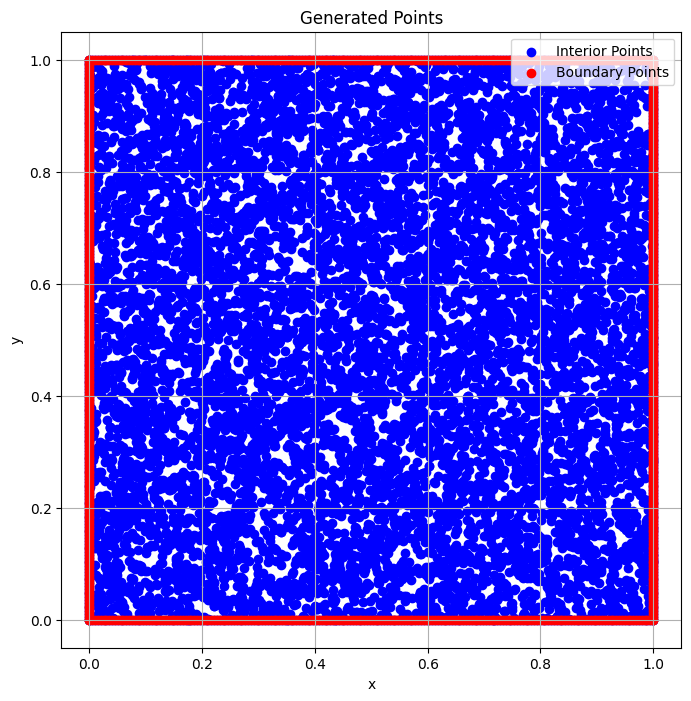

In [39]:
# Define domain boundaries and number of points
total_points = 10000
bound_points = 200
lower_bounds = np.array([0.0, 0.0])
upper_bounds = np.array([1.0, 1.0])

# Generate boundary points using LHS
bottom_edge = np.column_stack((np.linspace(0, 1, bound_points), np.zeros(bound_points)))
top_edge = np.column_stack((np.linspace(0, 1, bound_points), np.ones(bound_points)))
left_edge = np.column_stack((np.zeros(bound_points), np.linspace(0, 1, bound_points)))
right_edge = np.column_stack((np.ones(bound_points), np.linspace(0, 1, bound_points)))

# Combine all boundary points
boundary_points = np.vstack([bottom_edge, top_edge, left_edge, right_edge])

# Generate interior points using LHS
int_lhs = pyDOE.lhs(2, samples=total_points-bound_points*4)
int_points = int_lhs * (upper_bounds - lower_bounds) + lower_bounds

# Combine all points
points = np.vstack((boundary_points, int_points))
x_points = points[:, 0]
y_points = points[:, 1]

# Convert to TensorFlow tensors
x_points_tf = tf.convert_to_tensor(x_points, dtype=tf.float32)
y_points_tf = tf.convert_to_tensor(y_points, dtype=tf.float32)
boundary_points_tf = tf.convert_to_tensor(boundary_points, dtype=tf.float32)

#visualize the points
plt.figure(figsize=(8, 8))
plt.scatter(x_points, y_points, label='Interior Points', color='blue')
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], label='Boundary Points', color='red')
plt.grid(True)
plt.title('Generated Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 3. Define Neural Network Architecture

We'll use a feedforward neural network with the following structure:

* Input Layer: 2 neurons (x, y coordinates)
* Hidden Layers: 3 layers × 50 neurons with tanh activation
* Output Layer: 1 neuron (predicted u value)

In [40]:
#load model to device

#load model to device

## 4. Define the Source Function and PDE Residual

Here we define two key components with ω (omega) as a parameter to control the frequency of oscillations:

1. **Source Function f(x,y,ω)**:
  * Right-hand side of the Poisson equation ∇²u = f(x,y)
  * Defined as: f(x,y) = -2ω²sin(ωx)sin(ωy)
  * ω controls the frequency of the solution

2. **PDE Residual**:
  * Computes ∇²u = ∂²u/∂x² + ∂²u/∂y²
  * Measures how well our solution satisfies the PDE

In [41]:
def analytical_solution(x, y, omega=2.0*np.pi):
    """
    Compute analytical solution for the 2D Poisson equation
    Args:
        x: x coordinates (meshgrid)
        y: y coordinates (meshgrid)
        omega: frequency parameter (default: 2π)
    Returns:
        U: analytical solution on the given grid
    """
    return np.sin(omega * x) * np.sin(omega * y)

In [42]:
@tf.function
def f(x, y, omega=2.0*np.pi):
    """
    Source function with controllable frequency
    Args:
        x, y: spatial coordinates
        omega: frequency parameter (default: 2π)
    """
    # u = analytical_solution(x, y,omega=2.0*np.pi)
    # u_x = tf.gradients(u, x)[0]
    # u_y = tf.gradients(u, y)[0]
    # u_xx = tf.gradients(u_x, x)[0]
    # u_yy = tf.gradients(u_y, y)[0]
    # return -(u_xx + u_yy)

    return 2.0 * omega**2 * tf.math.sin(omega * x) * tf.math.sin(omega * y)


@tf.function
def pde(x, y, u, omega=2.0*np.pi):
    """
    PDE residual computation
    Args:
        x, y: spatial coordinates
        u: predicted solution
        omega: frequency parameter (default: 2π)
    """
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)
        tape1.watch(y)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            tape2.watch(y)
            u = model(tf.stack([x, y], axis=1))
        grad_x = tape2.gradient(u, x)  # First derivatives
        grad_y = tape2.gradient(u, y)
    grad2_x = tape1.gradient(grad_x, x)  # Second derivatives
    grad2_y = tape1.gradient(grad_y, y)

    return grad2_x + grad2_y + f(x, y, omega)

## 5. Loss Function Definition with Boundary Weight

The total loss combines:
1. **PDE Loss**: Measures Poisson equation satisfaction
2. **Boundary Loss**: Weighted term (β) for boundary conditions

In [43]:
@tf.function
def compute_loss(x, y, x_boundary, y_boundary, beta=10.0, omega=2.0*np.pi):
    """
    Compute total loss with weighted boundary conditions
    Args:
        x, y: coordinates for PDE loss
        x_boundary, y_boundary: coordinates for boundary conditions
        beta: weight for boundary loss (default: 10.0)
        omega: frequency parameter (default: 2π)
    Returns:
        total_loss, pde_loss, boundary_loss
    """
    # Compute PDE residual
    u = model(tf.stack([x, y], axis=1))
    residual_pde = pde(x, y, u, omega)
    pde_loss = tf.reduce_mean(tf.square(residual_pde))

    # Compute weighted boundary loss
    u_boundary = model(tf.stack([x_boundary, y_boundary], axis=1))
    boundary_loss = beta* tf.reduce_mean(tf.square(u_boundary))

    # Total loss
    total_loss = pde_loss + boundary_loss

    return total_loss, pde_loss, boundary_loss

## Training loop


In [44]:
n_epochs = 10000
omega=4.0*np.pi
beta = 10.0
history = {
    'total_loss': [],
    'pde_loss': [],
    'boundary_loss': []
}
with tf.device(device):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
    for epoch in range(n_epochs):

        with tf.GradientTape() as tape:
            loss, pde_loss, bc_loss = compute_loss(
                x_points_tf,
                y_points_tf,
                boundary_points_tf[:, 0],
                boundary_points_tf[:, 1],
                beta, omega)

        # Get gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Store losses
        history['total_loss'].append(loss.numpy())
        history['pde_loss'].append(pde_loss.numpy())
        history['boundary_loss'].append(bc_loss.numpy())

        # Print progress every 1000 epochs
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}:')
            print(f'  Total Loss: {loss.numpy():.6f}')
            print(f'  PDE Loss: {pde_loss.numpy():.6f}')
            print(f'  Boundary Loss: {bc_loss.numpy():.6f}\n')

Epoch 0:
  Total Loss: 22760.796875
  PDE Loss: 22759.294922
  Boundary Loss: 1.501061

Epoch 1000:
  Total Loss: 28.361805
  PDE Loss: 26.127457
  Boundary Loss: 2.234348

Epoch 2000:
  Total Loss: 31.476753
  PDE Loss: 30.573793
  Boundary Loss: 0.902959

Epoch 3000:
  Total Loss: 33.398499
  PDE Loss: 32.856861
  Boundary Loss: 0.541639

Epoch 4000:
  Total Loss: 9.520870
  PDE Loss: 9.088923
  Boundary Loss: 0.431948

Epoch 5000:
  Total Loss: 20.280073
  PDE Loss: 19.894506
  Boundary Loss: 0.385567

Epoch 6000:
  Total Loss: 71.240257
  PDE Loss: 70.986473
  Boundary Loss: 0.253788

Epoch 7000:
  Total Loss: 4.600493
  PDE Loss: 4.408963
  Boundary Loss: 0.191530

Epoch 8000:
  Total Loss: 34.508854
  PDE Loss: 34.318989
  Boundary Loss: 0.189863

Epoch 9000:
  Total Loss: 52.090828
  PDE Loss: 51.920094
  Boundary Loss: 0.170734




## Analytical Solution Function

Function to compute the analytical solution of the 2D Poisson equation:   

In [45]:
def analytical_solution(x, y, omega=2.0*np.pi):
    """
    Compute analytical solution for the 2D Poisson equation
    Args:
        x: x coordinates (meshgrid)
        y: y coordinates (meshgrid)
        omega: frequency parameter (default: 2π)
    Returns:
        U: analytical solution on the given grid
    """
    return np.sin(omega * x) * np.sin(omega * y)

## 7. Testing and Visualization

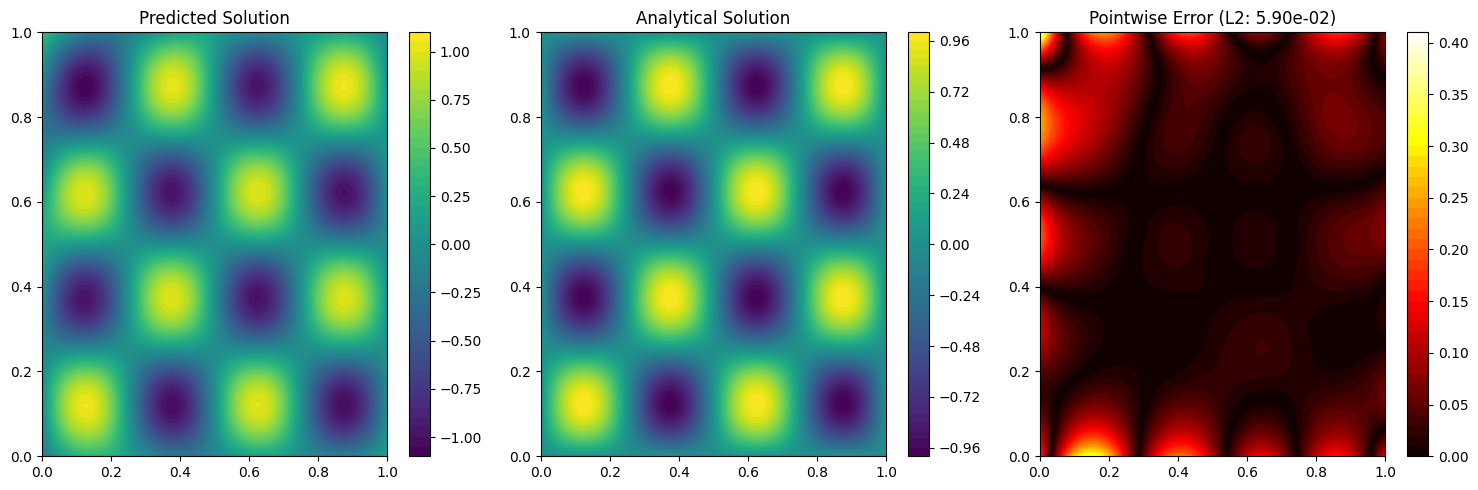


L2 Error: 5.90e-02


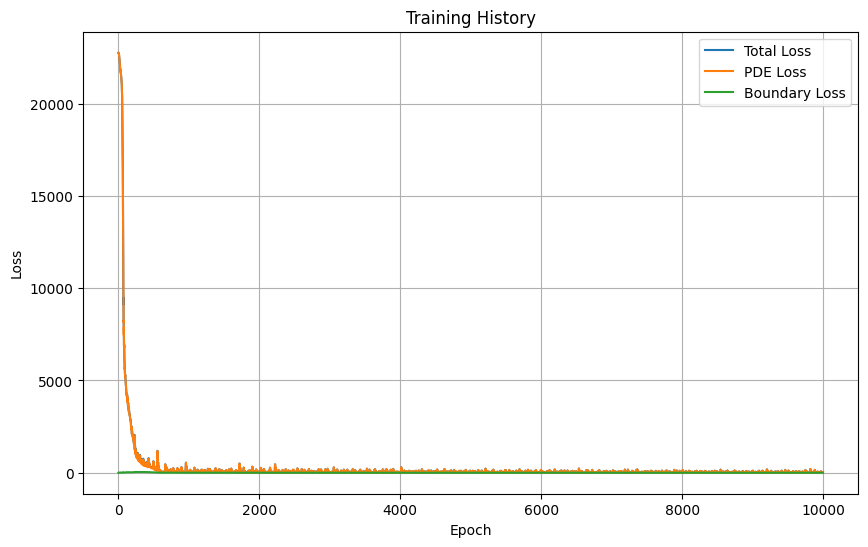

In [46]:
def plot_training_history(history):
    """Plot training history with regular scale"""
    plt.figure(figsize=(10, 6))
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['pde_loss'], label='PDE Loss')
    plt.plot(history['boundary_loss'], label='Boundary Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training History')
    plt.show()



def test_and_visualize(model, nx=100, ny=100):
    """
    Test PINN on a uniform grid and visualize results
    Args:
        model: trained PINN model
        nx, ny: number of points in x and y directions
    """
    # Generate uniform grid for testing
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)

    # Prepare input points
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    xy_test = np.stack([X_flat, Y_flat], axis=-1)

    # Get predictions
    u_pred = model(xy_test).numpy()
    U_pred = u_pred.reshape(nx, ny)

    U_analytical=analytical_solution(X, Y, omega)

    # Compute error
    error = np.abs(U_pred - U_analytical)
    l2_error = np.sqrt(np.mean((U_pred - U_analytical)**2))

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted solution
    im1 = axes[0].contourf(X, Y, U_pred, levels=50, cmap='viridis')
    axes[0].set_title('Predicted Solution')
    fig.colorbar(im1, ax=axes[0])


    # Plot analytical solution
    im2 = axes[1].contourf(X, Y, U_analytical, levels=50, cmap='viridis')
    axes[1].set_title('Analytical Solution')
    fig.colorbar(im2, ax=axes[1])

    # Plot pointwise error
    im3 = axes[2].contourf(X, Y, error, levels=50, cmap='hot')
    axes[2].set_title(f'Pointwise Error (L2: {l2_error:.2e})')
    fig.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

    return l2_error

# Test and visualize results
l2_error = test_and_visualize(model)
print(f'\nL2 Error: {l2_error:.2e}')

# Plot training history
plot_training_history(history)

### Inverse Problem

Modifying PINN for the inverse problem:
* Domain: Ω = (0,1)²
* Equation: -ϵ∆u(x) = f(x)
* Unknown parameter: ϵ (diffusion coefficient)
* Initial guess: ϵ₀ = 2.0
* True value: ϵ = 0.3

In [47]:
def analytical_solution_inverse(x, y):
    """
    Analytical solution for the inverse problem using TensorFlow functions.
    Args:
        x, y: spatial coordinates in [0,1]²
        epsilon: diffusion coefficient
    Returns:
        u: exact solution
    """
    EPS = 0.3
    val = tf.sin(x) * tf.tanh(x) * tf.exp(-1.0 * EPS * (x**2)) * 10
    return val

Text(0.5, 1.0, 'Analytical Solution')

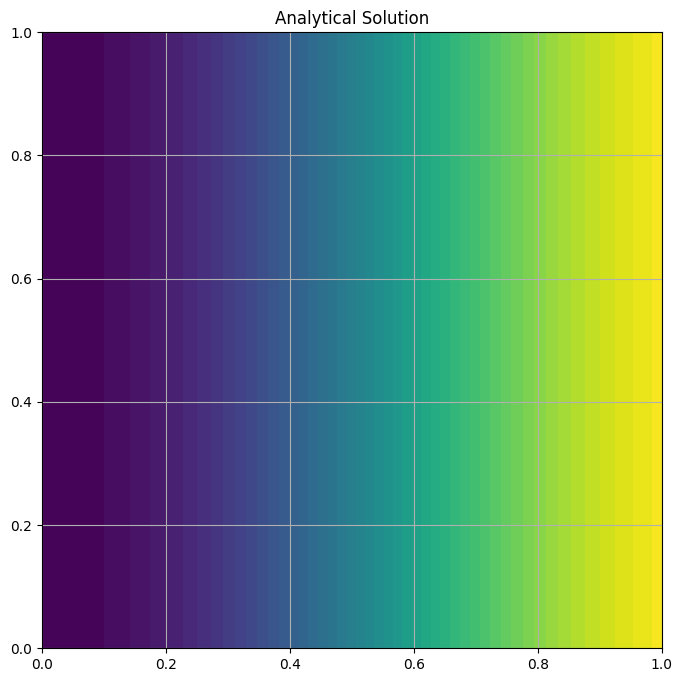

In [48]:
#plot analytical soln
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
U_analytical=analytical_solution_inverse(X, Y)
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, U_analytical, levels=50, cmap='viridis')
plt.grid(True)
plt.title('Analytical Solution')



In [49]:
def generate_sensor_data(n_sensors=50):
    """Generate random sensor locations and measurements"""
    # Random points in [0,1]²
    sensor_x = tf.random.uniform((n_sensors,), 0.0, 1.0)
    sensor_y = tf.random.uniform((n_sensors,), 0.0, 1.0)
    locations = tf.stack([sensor_x, sensor_y], axis=1)

    # True measurements
    epsilon_true = 0.3
    measurements = analytical_solution_inverse(sensor_x, sensor_y)

    return locations, measurements

In [50]:
# import sympy as sp

# # Define symbols
# x, y, eps = sp.symbols('x y eps')
# sin, tanh, exp = sp.sin, sp.tanh, sp.exp

# # Define the function u(x, y)
# u = 10 * sin(x) * tanh(x) * exp(-eps * (x**2))


# # Compute partial derivatives
# u_xx = sp.diff(u, x, x)  # Second derivative w.r.t. x
# u_yy = sp.diff(u, y, y)  # Second derivative w.r.t. y

# # Compute the Laplacian
# laplacian_u = u_xx + u_yy

# # Define f(x, y) = -eps * Laplacian of u
# f = -eps * laplacian_u

# # Simplify the result
# f_simplified = sp.simplify(f)

# # Output the results
# print("u(x, y):")
# print(u)
# print("\nLaplacian of u(x, y):")
# print(laplacian_u)
# print("\nf(x, y) = -eps * Laplacian of u(x, y):")
# print(f_simplified)


### 1. Source Term Function
The source term f(x,y) is calculated by applying the PDE operator to the known analytical solution:

In [51]:
def f(x, y):
    """
    Source function f(x,y) for the inverse problem, using TensorFlow functions.
    """
    EPS = 0.3
    #find diff square of u
    # u = analytical_solution_inverse(x, y)
    # u_x = tf.gradients(u, x)[0]
    # #u_y = tf.gradients(u, y)[0]
    # u_xx = tf.gradients(u_x, x)[0]
    # #u_yy = tf.gradients(u_y, y)[0]
    # return -EPS*(u_xx) #+ u_yy)

    # Using TensorFlow functions to ensure compatibility with computational graph
    return (
        -EPS
        * 10 * (
    4 * EPS * x * (tf.math.tanh(x)**2 - 1) * tf.math.sin(x)
    - 4 * EPS * x * tf.math.cos(x) * tf.math.tanh(x)
    + 2 * EPS * (2 * EPS * x**2 - 1) * tf.math.sin(x) * tf.math.tanh(x)
    + 2 * (tf.math.tanh(x)**2 - 1) * tf.math.sin(x) * tf.math.tanh(x)
    - 2 * (tf.math.tanh(x)**2 - 1) * tf.math.cos(x)
    - tf.math.sin(x) * tf.math.tanh(x)
) * tf.math.exp(-EPS * x**2)
    )

### 2. PDE Residual for Inverse Problem

In [52]:
@tf.function
def inverse_pde_residual(x, y, epsilon):
    """
    Compute PDE residual for the inverse Poisson problem: -ϵ∆u = f
    Args:
        x, y: spatial coordinates
    Returns:
        residual: PDE residual at given points
    """

    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)
        tape1.watch(y)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            tape2.watch(y)
            u = model(tf.stack([x, y], axis=1))
        grad_x = tape2.gradient(u, x)  # First derivatives
        grad_y = tape2.gradient(u, y)
    grad2_x = tape1.gradient(grad_x, x)  # Second derivatives
    grad2_y = tape1.gradient(grad_y, y)

    # PDE residual: -ϵ∆u = f
    residual = -epsilon *(grad2_x + grad2_y) - f(x, y)

    return residual

### 3. Inverse Problem with Multiple Loss Components

Loss function components:
1. **PDE Loss**: Measures equation satisfaction
2. **Sensor Loss**: Weighted term (α) for sensor measurements
3. **Boundary Loss**: Weighted term (β) for boundary conditions

In [53]:
@tf.function
def compute_losses(x, y, u_sensors, sensor_locations, x_boundary, y_boundary, epsilon, alpha=1.0, beta=1.0):
    """
    Compute all loss components
    Args:
        model: PINN model
        x, y: domain points
        u_sensors: sensor measurements
        sensor_locations: sensor coordinates
        x_boundary, y_boundary: boundary points
        alpha: weight for sensor loss
        beta: weight for boundary loss
    Returns:
        pde_loss, sensor_loss, boundary_loss
    """
    # PDE loss
    residual = inverse_pde_residual(x, y, epsilon)
    pde_loss = tf.reduce_mean(tf.square(residual))

    # Sensor loss
    u_pred = model(sensor_locations)
    sensor_loss = alpha * tf.reduce_mean(tf.square(u_pred - u_sensors))

    # Boundary loss
    u_boundary = model(tf.stack([x_boundary, y_boundary], axis=1))
    boundary_loss = beta * tf.reduce_mean(tf.square(u_boundary-analytical_solution_inverse(x_boundary,y_boundary)))

    return pde_loss, sensor_loss, boundary_loss

In [54]:
class CustomModel(tf.keras.Model):
    def __init__(self, epsilon_init=2.0):
        super(CustomModel, self).__init__()
        # Define the layers of the model
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1)

        # Define additional trainable variable epsilon
        self.epsilon = tf.Variable(epsilon_init, trainable=True, dtype=tf.float32, name="epsilon")

    def call(self, inputs):
        # Forward pass through the layers
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        output = self.output_layer(x)
        return output

# Create an instance of the custom model
model = CustomModel(epsilon_init=2.0)

In [55]:


# Training loop
n_sensors = 50
n_epochs = 10000
alpha = 10.0
beta = 10.0
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = {
    'pde_loss': [],
    'sensor_loss': [],
    'boundary_loss': []
}

locations, measurements = generate_sensor_data(n_sensors)
for epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        # Compute losses
        pde_loss, sensor_loss, boundary_loss = compute_losses(
            x_points_tf, y_points_tf, measurements, locations,
            boundary_points_tf[:, 0], boundary_points_tf[:, 1], model.epsilon,
            alpha, beta
        )

        # Total loss

        total_loss = pde_loss + sensor_loss + boundary_loss

    # Get gradients and update weights
    trainable_variables = model.trainable_variables + [model.epsilon]
    gradients = tape.gradient(total_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    # gradients = tape.gradient(total_loss, model.trainable_variables + [model.epsilon])
    # optimizer.apply_gradients(zip(gradients, model.trainable_variables + [model.epsilon]))

    # Store losses
    history['pde_loss'].append(pde_loss.numpy())
    history['sensor_loss'].append(sensor_loss.numpy())
    history['boundary_loss'].append(boundary_loss.numpy())

    # Print epsilon value
    print(f"Epoch {epoch}, Epsilon: {model.epsilon.numpy()}")

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}:')
        print(f'  PDE Loss: {pde_loss.numpy():.6f}')
        print(f'  Sensor Loss: {sensor_loss.numpy():.6f}')
        print(f'  Boundary Loss: {boundary_loss.numpy():.6f}\n')




Epoch 0, Epsilon: 2.0023438930511475
Epoch 0:
  PDE Loss: 12.999241
  Sensor Loss: 77.023392
  Boundary Loss: 96.153175

Epoch 1, Epsilon: 2.0047686100006104
Epoch 2, Epsilon: 2.007049083709717
Epoch 3, Epsilon: 2.0089609622955322
Epoch 4, Epsilon: 2.0100631713867188
Epoch 5, Epsilon: 2.0099759101867676
Epoch 6, Epsilon: 2.00894832611084
Epoch 7, Epsilon: 2.007413148880005
Epoch 8, Epsilon: 2.0056183338165283
Epoch 9, Epsilon: 2.0036792755126953
Epoch 10, Epsilon: 2.0016517639160156
Epoch 11, Epsilon: 1.9995644092559814
Epoch 12, Epsilon: 1.9974325895309448
Epoch 13, Epsilon: 1.9952653646469116
Epoch 14, Epsilon: 1.9930685758590698
Epoch 15, Epsilon: 1.9908462762832642
Epoch 16, Epsilon: 1.9886023998260498
Epoch 17, Epsilon: 1.986340880393982
Epoch 18, Epsilon: 1.9840669631958008
Epoch 19, Epsilon: 1.9817866086959839
Epoch 20, Epsilon: 1.9795078039169312
Epoch 21, Epsilon: 1.9772394895553589
Epoch 22, Epsilon: 1.9749919176101685
Epoch 23, Epsilon: 1.9727762937545776
Epoch 24, Epsilon: 

In [56]:
#training loop
n_sensors = 50
n_epochs = 10000
alpha = 10.0
beta = 10.0
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = {
    'pde_loss': [],
    'sensor_loss': [],
    'boundary_loss': []
}
#epsilon = tf.Variable(epsilon_init, dtype=tf.float32, trainable=True)
locations, measurements = generate_sensor_data(n_sensors)
for epoch in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape:
        # Compute losses
        pde_loss, sensor_loss, boundary_loss = compute_losses(x_points_tf, y_points_tf, measurements,locations,
            boundary_points_tf[:, 0], boundary_points_tf[:, 1],epsilon,
            alpha, beta)

        # Total loss
        total_loss = pde_loss + sensor_loss + boundary_loss

    # Get gradients and update weights
    gradients = tape.gradient(total_loss, model.trainable_variables+[epsilon])
    optimizer.apply_gradients(zip(gradients, model.trainable_variables+[epsilon]))
    epsilon_gradient = tape.gradient(total_loss, [epsilon])
    optimizer.apply_gradients(zip(epsilon_gradient, [epsilon]))


    del tape


    # Store losses
    history['pde_loss'].append(pde_loss.numpy())
    history['sensor_loss'].append(sensor_loss.numpy())
    history['boundary_loss'].append(boundary_loss.numpy())

    print(epsilon)

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}:')
        print(f'  PDE Loss: {pde_loss.numpy():.6f}')
        print(f'  Sensor Loss: {sensor_loss.numpy():.6f}')
        print(f'  Boundary Loss: {boundary_loss.numpy():.6f}\n')

NameError: name 'epsilon' is not defined

In [ ]:
def test_inverse_problem(model, nx=40, ny=40):
    """Test the inverse problem solution"""
    # Generate uniform grid
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)

    # Prepare input points
    xy_test = np.stack([X.flatten(), Y.flatten()], axis=-1)

    # Get predictions
    u_pred = model(xy_test).numpy().reshape(nx, ny)

    # Compute analytical solution
    U_analytical = analytical_solution_inverse(X, Y, 0.3)  # true epsilon

    # Compute error
    error = np.abs(u_pred - U_analytical)
    l2_error = np.sqrt(np.mean((u_pred - U_analytical)**2))

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    im1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis')
    axes[0].set_title('Predicted Solution')
    fig.colorbar(im1, ax=axes[0])

    im2 = axes[1].contourf(X, Y, U_analytical, levels=50, cmap='viridis')
    axes[1].set_title('Analytical Solution')
    fig.colorbar(im2, ax=axes[1])

    im3 = axes[2].contourf(X, Y, error, levels=50, cmap='hot')
    axes[2].set_title(f'Error (L2: {l2_error:.2e})')
    fig.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

    print(f'Predicted ϵ: {float(epsilon):.6f}')
    print(f'L2 Error: {l2_error:.2e}')

In [ ]:
print(f'Predicted ϵ: {float(epsilon):.6f}')


In [ ]:
import sympy as sp

# Define symbols
x, y, eps = sp.symbols('x y eps')
sin, tanh, exp = sp.sin, sp.tanh, sp.exp

# Define the function u(x, y)
u = 10 * sin(x) * tanh(x) * exp(-eps * (x**2))


# Compute partial derivatives
u_xx = sp.diff(u, x, x)  # Second derivative w.r.t. x
u_yy = sp.diff(u, y, y)  # Second derivative w.r.t. y

# Compute the Laplacian
laplacian_u = u_xx + u_yy

# Define f(x, y) = -eps * Laplacian of u
f = -eps * laplacian_u

# Simplify the result
f_simplified = sp.simplify(f)

# Output the results
print("u(x, y):")
print(u)
print("\nLaplacian of u(x, y):")
print(laplacian_u)
print("\nf(x, y) = -eps * Laplacian of u(x, y):")
print(f_simplified)
